In [ ]:
#| default_exp selfsupervised.jigsaw_puzzle

# Jigsaw Puzzle

> Simple implementation of the Jigsaw Puzzle self-supervised task for TensorFlow. It is intented to be used with every dataset as plug and play feature.

In [ ]:
#| eval: false
#| hide
import matplotlib.pyplot as plt

In [ ]:
#| export
from itertools import permutations

import numpy as np
from einops import rearrange
import tensorflow as tf

This could be implemented as a function that uses out of scope variables, but as we want to have everything as packed as possible, we're going to define a `class` that stores the possible combinations and the methods needed to invert the permutations in order to de-puzzle a puzzled image.

In [ ]:
#| export
class JigsawPuzzle():
    """Class that supports all the logic needed to perform a jigsaw puzzle self-supervision task."""
    
    def __init__(self,
                 n_tiles, # Number of tiles per puzzle.
                 ):
        self.n_tiles = n_tiles
        self.permutations = list(permutations(range(n_tiles)))
        self.labels = list(range(len(self.permutations)))
        self.permutations2labels = {perm:label for perm, label in zip(self.permutations, self.labels)}
        self.labels2permutations = {label:perm for perm, label in zip(self.permutations, self.labels)}
    
    @property
    def possible_permutations(self):
        return len(self.permutations)

    def make_puzzle(self,
                    img, # Image we want to puzzle. (HxWxC)
                    ): # Puzzled image. (N_Tilesx(H/sqrt(N_Tiles))x(W/sqrt(N_Tiles))xC)
        """Takes as input an image and returns an array containing the puzzled image."""
        ## 1. Create patches
        h, w = img.shape[0:2]
        h_tile, w_tile = int(h) // int(np.sqrt(self.n_tiles)), int(w) // int(np.sqrt(self.n_tiles))
        puzzle = rearrange(img, "(h h2) (w w2) c -> (h w) h2 w2 c", h2=h_tile, w2=w_tile)

        ## 2. Obtain a random permutation
        idx = tf.random.categorical(tf.math.log([tf.ones(self.possible_permutations)/self.possible_permutations]), 1, dtype=tf.int32)[0][0]
        permutation = tf.gather(self.permutations, idx)
        permutation_label = tf.gather(self.labels, idx)
        ## 3. Rearrange the puzzle according to the permutation 
        puzzle = tf.gather(puzzle, indices=permutation)

        return puzzle, permutation_label
    
    def assemble_puzzle(self,
                        puzzle, # Puzzled image to be reassembled
                        ):
        return rearrange(puzzle, "(nh nw) h w c -> (nh h) (nw w) c", nh=self.n_tiles//2, nw=self.n_tiles//2)

    def invert_puzzle(self,
                      puzzle, # Puzzled image.
                      permutation, # Permutation used to create the puzzle.
                      return_full_image=True, # Wether to return the full image or an array of the separated tiles.
                      return_permutation=False, # Wether to return the permutation that inverses the original permutation or not.
                      ):
        """Takes a puzzle and the permutation that produced it and returns the de-puzzled image."""
        if not isinstance(permutation, np.ndarray): permutation = np.array(permutation)
        inv = np.empty_like(permutation)
        inv[permutation] = np.arange(permutation.shape[0])
        original_img = tf.gather(puzzle, inv)
        original_img = self.assemble_puzzle(original_img)
        if return_permutation: return original_img, inv
        else: return original_img

In [ ]:
red = np.ones(shape=(16,16,3))*np.array([255,0,0])[None,None,:]
blue = np.ones(shape=(16,16,3))*np.array([0,255,0])[None,None,:]
green = np.ones(shape=(16,16,3))*np.array([0,0,255])[None,None,:]
white = np.ones(shape=(16,16,3))*np.array([255,255,255])[None,None,:]
red_blue = np.concatenate([red, blue], axis=1)
green_white = np.concatenate([green, white], axis=1)
img = np.concatenate([red_blue, green_white], axis=0)
red_blue.shape, green_white.shape, img.shape

((16, 32, 3), (16, 32, 3), (32, 32, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


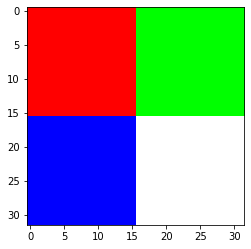

In [ ]:
#| eval: false
plt.imshow(img)
plt.show()

In [ ]:
puzler = JigsawPuzzle(n_tiles=4)

In [ ]:
img_puzzle, label = puzler.make_puzzle(img)
permutation =  puzler.labels2permutations[label.numpy()]
img_puzzle.shape, label, permutation

(TensorShape([4, 16, 16, 3]),
 <tf.Tensor: shape=(), dtype=int32, numpy=5>,
 (0, 3, 2, 1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


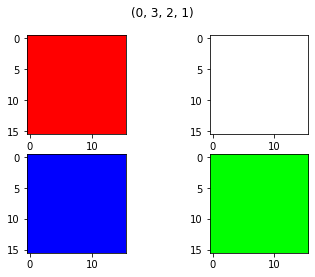

In [ ]:
#| eval: false
fig, axes = plt.subplots(2,2)
for tile, ax in zip(img_puzzle, axes.ravel()):
    ax.imshow(tile)
plt.suptitle(permutation)
plt.show()

In [ ]:
inverted_img, inverted_permutation = puzler.invert_puzzle(img_puzzle, permutation, return_full_image=True, return_permutation=True)
inverted_img.shape, inverted_permutation

(TensorShape([32, 32, 3]), array([0, 3, 2, 1]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


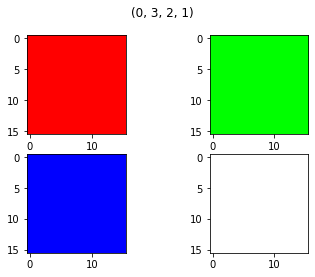

In [ ]:
#| eval: false
fig, axes = plt.subplots(2,2)
for tile, ax in zip(tf.gather(img_puzzle, inverted_permutation), axes.ravel()):
    ax.imshow(tile)
plt.suptitle(permutation)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


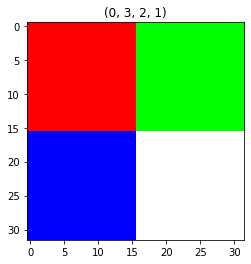

In [ ]:
#| eval: false
plt.imshow(inverted_img)
plt.title(permutation)
plt.show()

## Using it with a `tf.data.Dataset`

In [ ]:
#| eval: false
def sample_dataset():
    for i in range(20):
        red = np.ones(shape=(16,16,3))*np.array([255,0,0])[None,None,:]
        blue = np.ones(shape=(16,16,3))*np.array([0,255,0])[None,None,:]
        green = np.ones(shape=(16,16,3))*np.array([0,0,255])[None,None,:]
        white = np.ones(shape=(16,16,3))*np.array([255,255,255])[None,None,:]
        red_blue = np.concatenate([red, blue], axis=1)
        green_white = np.concatenate([green, white], axis=1)
        img = np.concatenate([red_blue, green_white], axis=0)
        yield img

In [ ]:
#| eval: false
dst = tf.data.Dataset.from_generator(sample_dataset,
                                     output_signature=(
                                        tf.TensorSpec(shape=(32,32,3), dtype=tf.float32)
                                     ))
puzler = JigsawPuzzle(n_tiles=4)
dst_puzzle = dst.map(puzler.make_puzzle)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 32, 3)


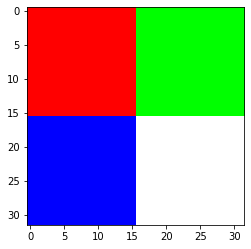

In [ ]:
#| eval: false
for img in dst:
    print(img.shape)
    break
plt.imshow(img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 16, 16, 3)


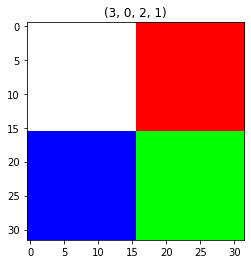

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


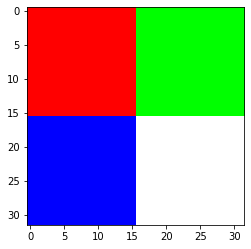

In [ ]:
#| eval: false
for img, perm in dst_puzzle:
    print(img.shape)
    break
perm = puzler.labels2permutations[perm.numpy()]
img_ = puzler.invert_puzzle(img, perm)
plt.imshow(puzler.assemble_puzzle(img))
plt.title(perm)
plt.show()
plt.imshow(img_)
plt.show()